# Vehicle Loan Default Prediction - Model Improvement

This notebook builds upon the preprocessing steps from `02_data_preprocessing_and_feature_engineering.ipynb` but focuses on improving model performance by:
1. **Correcting SMOTE Usage**: Applying SMOTE only to the training set after splitting to prevent data leakage.
2. **Hyperparameter Tuning**: Using RandomizedSearchCV to find better parameters for XGBoost.
3. **Advanced Evaluation**: Analyzing ROC-AUC and Precision-Recall tradeoffs.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')

## 1. Data Loading and Preprocessing
We will replicate the effective preprocessing steps identified in the previous notebook.

In [16]:
# Load data
try:
    df = pd.read_csv('../data/train.csv')
    print(f'Data loaded: {df.shape}')
except FileNotFoundError:
    print("Error: '../data/train.csv' not found. Please check the path.")

Data loaded: (233154, 41)


In [17]:
# --- FEATURE ENGINEERING FUNCTIONS ---

def apply_smoothed_encoding(df, target_col, id_cols, m=15):
    """Calculates smoothed target encoding."""
    global_mean = df[target_col].mean()
    for col in id_cols:
        agg = df.groupby(col)[target_col].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        smooth_val = (counts * means + m * global_mean) / (counts + m)
        df[f'{col}_risk_score'] = df[col].map(smooth_val)
        df.drop(columns=[col], inplace=True)
    return df

def convert_to_months(duration_str):
    """Converts 'Xyrs Ymon' to total months."""
    import re
    if pd.isna(duration_str) or duration_str == "":
        return 0
    years = re.findall(r'(\d+)yrs', duration_str)
    months = re.findall(r'(\d+)mon', duration_str)
    total = 0
    if years: total += int(years[0]) * 12
    if months: total += int(months[0])
    return total

def group_bureau_score(desc):
    """Groups bureau score descriptions."""
    if desc in ['A-Very Low Risk', 'B-Very Low Risk', 'C-Very Low Risk', 'D-Very Low Risk']:
        return 'Very_Low_Risk'
    elif desc in ['E-Low Risk', 'F-Low Risk', 'G-Low Risk']:
        return 'Low_Risk'
    elif desc in ['H-Medium Risk', 'I-Medium Risk']:
        return 'Medium_Risk'
    elif desc in ['J-High Risk', 'K-High Risk']:
        return 'High_Risk'
    elif desc in ['L-Very High Risk', 'M-Very High Risk']:
        return 'Very_High_Risk'
    else:
        return 'No_History_or_Not_Scored'

In [18]:
# --- APPLY TRANSFORMATIONS ---

# 1. Drop ID & Irrelevant Columns
cols_to_drop = ['UniqueID', 'Sr. NO', 'MobileNo_Avl_Flag', 'Employee_code_ID', 'Current_pincode_ID']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Target Encoding for High-Cardinality IDs
ids_to_encode = ['branch_id', 'supplier_id', 'manufacturer_id', 'State_ID']
df = apply_smoothed_encoding(df, 'loan_default', ids_to_encode)

# 3. Financial Features & Log Transform
df['down_payment'] = df['asset_cost'] - df['disbursed_amount']
df['total_monthly_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']
df['installment_to_loan_ratio'] = df['total_monthly_installment'] / (df['disbursed_amount'] + 1)

amount_cols_to_log = ['disbursed_amount', 'asset_cost', 'down_payment', 'total_monthly_installment']
for col in amount_cols_to_log:
    df[f'log_{col}'] = np.log1p(df[col])

# Drop original financial columns
cols_to_drop_fin = ['disbursed_amount', 'asset_cost', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'down_payment', 'total_monthly_installment']
df.drop(columns=cols_to_drop_fin, inplace=True, errors='ignore')

# 4. Date Features
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], dayfirst=True)
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], dayfirst=True)
df['Age_at_Disbursal'] = (df['DisbursalDate'] - df['Date.of.Birth']).dt.days // 365
df['Disbursal_Month'] = df['DisbursalDate'].dt.month
df['Average_Acct_Age_Months'] = df['AVERAGE.ACCT.AGE'].apply(convert_to_months)
df['Credit_History_Length_Months'] = df['CREDIT.HISTORY.LENGTH'].apply(convert_to_months)

cols_to_drop_dates = ['Date.of.Birth', 'DisbursalDate', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']
df.drop(columns=cols_to_drop_dates, inplace=True)

# 5. Bureau & History Features
df['Total_No_of_Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df['Total_Active_Accounts'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']
df['Total_Overdue_Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df['Total_Current_Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']

df['Bureau_Score_Category'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(group_bureau_score)
risk_order = {'No_History_or_Not_Scored': 0, 'Very_Low_Risk': 1, 'Low_Risk': 2, 'Medium_Risk': 3, 'High_Risk': 4, 'Very_High_Risk': 5}
df['Bureau_Score_Category_Encoded'] = df['Bureau_Score_Category'].map(risk_order)

df['log_Total_Current_Balance'] = np.log1p(df['Total_Current_Balance'])
df['log_Total_Current_Balance'] = df['log_Total_Current_Balance'].replace([np.inf, -np.inf], 0).fillna(0)

cols_to_drop_bureau = [
    'PRI.NO.OF.ACCTS', 'SEC.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'SEC.ACTIVE.ACCTS', 
    'PRI.OVERDUE.ACCTS', 'SEC.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE', 
    'PRI.SANCTIONED.AMOUNT', 'SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 
    'PERFORM_CNS.SCORE.DESCRIPTION', 'Bureau_Score_Category', 'Total_Current_Balance'
]
df.drop(columns=cols_to_drop_bureau, inplace=True, errors='ignore')

# 6. Employment & KYC
df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')
emp_map = {'Salaried': 0, 'Self Employed': 1}
df['Employment_Type_Encoded'] = df['Employment.Type'].map(emp_map).fillna(2).astype(int)
df.drop(columns=['Employment.Type'], inplace=True)

flag_cols = ['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag']
df['Total_KYC_Documents'] = df[flag_cols].sum(axis=1)
df.drop(columns=flag_cols, inplace=True)

# 7. Feature Selection (based on previous VIF analysis)
# Keeping only the most relevant features identified in previous analysis
features_to_keep = [
    'branch_id_risk_score', 'supplier_id_risk_score', 'ltv', 
    'Credit_History_Length_Months', 'Total_Active_Accounts', 
    'Average_Acct_Age_Months', 'log_Total_Current_Balance', 
    'Bureau_Score_Category_Encoded', 'PERFORM_CNS.SCORE', 
    'Total_No_of_Accounts', 'log_total_monthly_installment', 
    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'Total_Overdue_Accounts', 
    'Employment_Type_Encoded', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 
    'NO.OF_INQUIRIES', 'Age_at_Disbursal', 'installment_to_loan_ratio'
]

X = df[features_to_keep]
y = df['loan_default']

print("Preprocessing Complete.")
print(f"Final Feature Set Shape: {X.shape}")

Preprocessing Complete.
Final Feature Set Shape: (233154, 18)


## 2. Correct Data Splitting & SMOTE
Here we perform the split *before* resampling to avoid data leakage. The test set must remain 'pure' (unseen, original distribution).

In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}, Class 1 Ratio: {y_train.mean():.2%}")
print(f"Test Set: {X_test.shape}, Class 1 Ratio: {y_test.mean():.2%}")

# NOTE: We will use SMOTE inside a pipeline or apply it now to X_train only
print("\nApplying SMOTE to Training set only...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled Training Set: {X_train_resampled.shape}, Class 1 Ratio: {y_train_resampled.mean():.2%}")

Training Set: (186523, 18), Class 1 Ratio: 21.71%
Test Set: (46631, 18), Class 1 Ratio: 21.71%

Applying SMOTE to Training set only...
Resampled Training Set: (292068, 18), Class 1 Ratio: 50.00%


## 3. Model Training & Improvement

### 3.1 Baseline: Logistic Regression (with SMOTE)

In [20]:
# Scale the data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train_resampled)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("--- Logistic Regression (with SMOTE) ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

--- Logistic Regression (with SMOTE) ---
ROC-AUC: 0.6602
              precision    recall  f1-score   support

           0       0.85      0.62      0.72     36509
           1       0.31      0.61      0.41     10122

    accuracy                           0.62     46631
   macro avg       0.58      0.61      0.56     46631
weighted avg       0.73      0.62      0.65     46631



### 3.2 Advanced: XGBoost (Hyperparameter Tuning)
We will tune XGBoost using `RandomizedSearchCV`. We will compare using `scale_pos_weight` (built-in weighting) vs. SMOTE.

In [21]:
# Strategy A: XGBoost with SMOTE Data
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_smote.fit(X_train_resampled, y_train_resampled)
y_prob_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]
print(f"XGBoost (SMOTE) ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_smote):.4f}")

# Strategy B: XGBoost with Class Weights (scale_pos_weight)
# Calculate ratio
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb_weighted = XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_weighted.fit(X_train, y_train) # Note: Original Imbalanced X_train
y_prob_xgb_weighted = xgb_weighted.predict_proba(X_test)[:, 1]
print(f"XGBoost (Weighted) ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_weighted):.4f}")

XGBoost (SMOTE) ROC-AUC: 0.6469
XGBoost (Weighted) ROC-AUC: 0.6712


### 3.3 Hyperparameter Tuning
Let's tune the Weighted XGBoost as it often performs better/faster than SMOTE for trees.

In [22]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5]
}

xgb_model = XGBClassifier(
    scale_pos_weight=ratio, 
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=20, 
    scoring='roc_auc', 
    cv=3, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

print("Starting Hyperparameter Tuning (this may take 2-5 mins)...")
random_search.fit(X_train, y_train)

print(f"Best ROC-AUC: {random_search.best_score_:.4f}")
print(f"Best Params: {random_search.best_params_}")

Starting Hyperparameter Tuning (this may take 2-5 mins)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best ROC-AUC: 0.6788
Best Params: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}


## 4. Final Evaluation
We evaluate the best model on the test set using multiple metrics.

--- Final Improved Model Performance ---
ROC-AUC Score: 0.6787

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71     36509
           1       0.31      0.66      0.42     10122

    accuracy                           0.61     46631
   macro avg       0.59      0.63      0.57     46631
weighted avg       0.74      0.61      0.65     46631



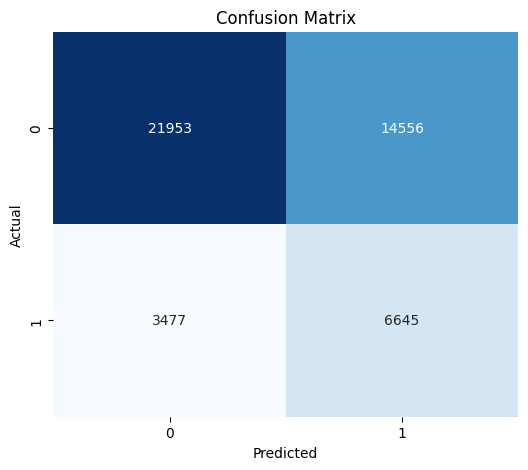


--- Confusion Matrix Metrics ---
True Negatives (TN): 21953
False Positives (FP): 14556
False Negatives (FN): 3477
True Positives (TP): 6645
Specificity (True Negative Rate): 0.6013
Sensitivity (Recall/True Positive Rate): 0.6565


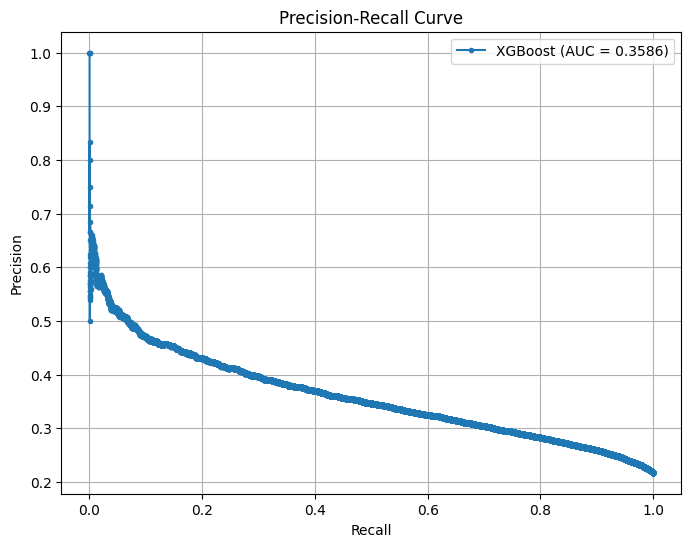

In [23]:
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("--- Final Improved Model Performance ---")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix Metrics
tn, fp, fn, tp = cm.ravel()
print("\n--- Confusion Matrix Metrics ---")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Specificity & Sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn) # Recall
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {sensitivity:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'XGBoost (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()